In [1]:
import datetime
import os
import numpy as np
import scipy.io as sio
import torch
from torch import nn, optim
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")

In [3]:
def read_data(base_path='./Data',split_size=[0.6, 0.2, 0.2]):  #  the split_size gives how much of the data goes to the train/test.
    """
    Reads all of the .mat files in the given base_path, and returns a dict with the data found there.
    :param split_size:
    :param base_path: The directory that should be read in.
    :return: a dict, containing the EES and difference tensors.
    """
    i = 0
    for file in os.listdir(base_path):
        i = i + 1
    pbar = tqdm(total=i)

    data_dict = {}
    for file in os.listdir(base_path):
        num, data_type = file.split('_')
        data_type = data_type.split('.')[0]
        num = int(num)
        if "EES" in data_type:
            tensor_in = sio.loadmat(os.path.join(base_path, file))['EES_value']
            tensor_in = torch.FloatTensor(tensor_in).squeeze(0)
        else:
            tensor_in = sio.loadmat(os.path.join(base_path, file))['Kulonbseg']
            tensor_in = torch.FloatTensor(tensor_in)
        try:
            data_dict[num][data_type] = tensor_in
        except KeyError:
            data_dict[num] = {data_type: tensor_in}
        pbar.update()
    pbar.close()

    new_data = []
    for key in data_dict.keys():
        new_data.append(data_dict[key])
    np.random.shuffle(new_data)
    if isinstance(split_size, list):
        training_samples = int(split_size[0] * len(new_data))
        valid_samples = int(split_size[1] * len(new_data))
        test_samples = int(split_size[2] * len(new_data))
        while sum([training_samples, valid_samples, test_samples]) != len(new_data):
            training_samples += 1
        #split samples
        new_datadict = {'train': new_data[:training_samples],
                        'validation': new_data[training_samples + 1:training_samples + valid_samples],
                        'test': new_data[-test_samples:]}
    else:
        new_datadict = {'train': new_data,
                        'validation': new_data,
                        'test': new_data}
    print("Adatbetöltés kész")
    return new_datadict

In [4]:
class CarBadnessGuesser(nn.Module):
    def __init__(self, lr=0.01):
        super(CarBadnessGuesser, self).__init__()

        self.dataset = read_data()
        self.valid_freq = 10

        self.model = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=3, kernel_size=(10, 5, 5), stride=(10, 5, 5)),
            nn.BatchNorm3d(3),
            nn.Conv3d(in_channels=3, out_channels=2, kernel_size=5),
            nn.BatchNorm3d(2),
            nn.Conv3d(in_channels=2, out_channels=1, kernel_size=3),
            nn.BatchNorm3d(1),
            nn.AdaptiveMaxPool3d((1, 1, 10)),
        ) 
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=10, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=1),
            nn.ReLU()
        )
        if torch.cuda.is_available():
            self.linear.cuda()
            self.model.cuda()

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(list(self.model.parameters()) + list(self.linear.parameters()), lr=lr)


    # 0: no damage, 1: slightly damaged, 2: damaged, 3: very damaged
    def getClass(self, x):
        if x==0:
            return 0      
        x = int(x)
        if x<=100/3:
            return 1
        elif  x>100/3 and x<200/3:
            return 2
        else:
            return 3
    
    # compare prediction and label classes
    def isCorrect(self, prediction, label):
        return self.getClass(prediction) == self.getClass(label)

    def forward(self, x):
        conv_out = self.model(x.unsqueeze(0).unsqueeze(0))
        return self.linear(conv_out.squeeze(-2).squeeze(-2))

    def train(self, epochs=50):
        b_loss = []
        v_loss = []
    
        for epoch in trange(epochs):
            t_correct = 0
            total = 1
            for step, data in enumerate(self.dataset["train"]):
                input_data = data['KUL'].cuda()
                label = data['EES'].cuda()
                
                prediction = self(input_data)
                loss = self.loss_fn(prediction, label)
                #print('training- ', 'y^', prediction.item(), 'y', label.item(), loss.item())
                #print('t_correct', t_correct, 'total',total)
                
                loss.backward()     
                self.optimizer.step()
                b_loss.append(loss.item())
                
                #check if its prediction matches label class
                if( self.isCorrect(prediction.item(), label.item()) ):
                    t_correct += 1;
                total += 1;
                
                self.zero_grad()
            if epoch % self.valid_freq and epoch != 0:
                #calculate the training accuracy
                t_acc = t_correct/total * 100
                #print(f'Batch loss: {loss.item()}', flush=True)
             
                vloss, v_acc = self.validation()
                v_loss.append(vloss)
                print(f'Validation loss:', vloss, flush=True)

                
        print('Training acc:', t_acc, '%')
        print('Validation acc: ', v_acc, '%')  
        self.save_weights()
        
        plt.plot(v_loss)
        plt.ylabel('Validation loss')
        plt.show()
        plt.plot(b_loss)
        plt.ylabel('Batch loss')
        plt.show()

    def validation(self):
        """
        Runs the validation phase of the training
        :return: The validation loss average
        """
        v_correct = 0
        total = 1
        average_loss = 0
        step = 0
        
        for step, data in enumerate(self.dataset['validation']):
            with torch.no_grad():
                input_data = data['KUL'].cuda()
                label = data['EES'].cuda()
                
                prediction = self(input_data)
                loss = self.loss_fn(prediction, label)               
                #print('validation- ', 'y^', prediction.item(), 'y', label.item(), loss.item())
                #print('v_correct', v_correct, 'total',total)
                
                average_loss += loss.item()
                
                #check if its correct
                c = self.isCorrect(prediction.item(), label.item())
                if(c == True):
                    v_correct += 1;
                total += 1;
        
        #calculate the validation accuracy
        v_correct = v_correct/total * 100  
        return average_loss / (step + 1), v_correct
        print("Validation is complete")

    def test(self):
        """
        Runs the evaluation of the network.
        :return: average loss for the test
        """
        average_loss = 0
        step = 0
        for step, data in enumerate(self.dataset['test']):
            with torch.no_grad():
                input_data = data['KUL'].cuda()
                prediction = self(input_data)
                loss = self.loss_fn(prediction, data['EES'].cuda())
                average_loss += loss.item()
        return average_loss / step
        print("the test is complete")

    def save_weights(self, save_dir="./training"):
        """
        Saves weights to the given directory plus the timestamp
        :return: none
        """
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S.%d")
        save_path = os.path.join(save_dir, timestamp)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(list(self.model.parameters()) +
                   list(self.linear.parameters()), os.path.join(save_path, 'model.weights'))
        print("saving weights is complete")

    def load_weights(self):
        self.optimizer = torch.load('model.weights')
        print("loading is complete")


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Adatbetöltés kész


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\igorr\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1/50 [00:01<01:19,  1.62s/it]

Validation loss: 166.21587450140052


  4%|▍         | 2/50 [00:03<01:17,  1.61s/it]

Validation loss: 142.92496264881143


  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

Validation loss: 124.14947986064686


  8%|▊         | 4/50 [00:06<01:12,  1.57s/it]

Validation loss: 118.77391293976042


 10%|█         | 5/50 [00:07<01:10,  1.57s/it]

Validation loss: 115.74551741282146


 12%|█▏        | 6/50 [00:09<01:08,  1.56s/it]

Validation loss: 134.9290657573276


 14%|█▍        | 7/50 [00:10<01:06,  1.55s/it]

Validation loss: 141.3548961215549


 16%|█▌        | 8/50 [00:12<01:05,  1.55s/it]

Validation loss: 135.07390975952148


 18%|█▊        | 9/50 [00:14<01:03,  1.55s/it]

Validation loss: 128.4370724360148


 22%|██▏       | 11/50 [00:16<00:58,  1.49s/it]

Validation loss: 115.28587484359741


 24%|██▍       | 12/50 [00:18<00:57,  1.51s/it]

Validation loss: 109.48650153477986


 26%|██▌       | 13/50 [00:20<00:56,  1.52s/it]

Validation loss: 101.22560352749295


 28%|██▊       | 14/50 [00:21<00:54,  1.52s/it]

Validation loss: 94.8962607913547


 30%|███       | 15/50 [00:23<00:53,  1.54s/it]

Validation loss: 87.33923261612654


 32%|███▏      | 16/50 [00:24<00:52,  1.55s/it]

Validation loss: 78.38030428397987


 34%|███▍      | 17/50 [00:26<00:51,  1.56s/it]

Validation loss: 71.6204390393363


 36%|███▌      | 18/50 [00:27<00:49,  1.56s/it]

Validation loss: 64.37183231777615


 38%|███▊      | 19/50 [00:29<00:48,  1.56s/it]

Validation loss: 56.489040012160935


 42%|████▏     | 21/50 [00:32<00:43,  1.49s/it]

Validation loss: 45.20223827742868


 44%|████▍     | 22/50 [00:33<00:42,  1.51s/it]

Validation loss: 44.585806899600556


 46%|████▌     | 23/50 [00:35<00:41,  1.52s/it]

Validation loss: 34.94321547448635


 48%|████▊     | 24/50 [00:36<00:39,  1.53s/it]

Validation loss: 33.6255843722158


 50%|█████     | 25/50 [00:38<00:38,  1.53s/it]

Validation loss: 29.581045451263588


 52%|█████▏    | 26/50 [00:40<00:36,  1.54s/it]

Validation loss: 28.764702704217697


 54%|█████▍    | 27/50 [00:41<00:35,  1.54s/it]

Validation loss: 21.259778287675644


 56%|█████▌    | 28/50 [00:43<00:34,  1.55s/it]

Validation loss: 24.506396300262875


 58%|█████▊    | 29/50 [00:44<00:32,  1.56s/it]

Validation loss: 18.68502794040574


 62%|██████▏   | 31/50 [00:47<00:28,  1.48s/it]

Validation loss: 12.709591228100988


 64%|██████▍   | 32/50 [00:49<00:27,  1.50s/it]

Validation loss: 12.375085768600306


 66%|██████▌   | 33/50 [00:50<00:25,  1.52s/it]

Validation loss: 12.548975699063805


 68%|██████▊   | 34/50 [00:52<00:24,  1.52s/it]

Validation loss: 11.02503799729877


 70%|███████   | 35/50 [00:53<00:23,  1.54s/it]

Validation loss: 10.394021098812422


 72%|███████▏  | 36/50 [00:55<00:21,  1.54s/it]

Validation loss: 9.07040354775058


 74%|███████▍  | 37/50 [00:56<00:20,  1.55s/it]

Validation loss: 8.918087547024092


 76%|███████▌  | 38/50 [00:58<00:18,  1.54s/it]

Validation loss: 8.138143000503382


 78%|███████▊  | 39/50 [01:00<00:16,  1.54s/it]

Validation loss: 7.745661838187112


 82%|████████▏ | 41/50 [01:02<00:13,  1.46s/it]

Validation loss: 10.861401063493556


 84%|████████▍ | 42/50 [01:04<00:11,  1.48s/it]

Validation loss: 8.19861369000541


 86%|████████▌ | 43/50 [01:05<00:10,  1.50s/it]

Validation loss: 9.645916177891195


 88%|████████▊ | 44/50 [01:07<00:09,  1.50s/it]

Validation loss: 10.41124818018741


 90%|█████████ | 45/50 [01:08<00:07,  1.51s/it]

Validation loss: 8.356053191754553


 92%|█████████▏| 46/50 [01:10<00:06,  1.52s/it]

Validation loss: 6.702810724576314


 94%|█████████▍| 47/50 [01:12<00:04,  1.53s/it]

Validation loss: 5.980886526535162


 96%|█████████▌| 48/50 [01:13<00:03,  1.53s/it]

Validation loss: 6.567266033962369


 98%|█████████▊| 49/50 [01:15<00:01,  1.52s/it]

Validation loss: 8.072443046503597


100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Training acc: 93.54838709677419 %
Validation acc:  80.0 %
saving weights is complete


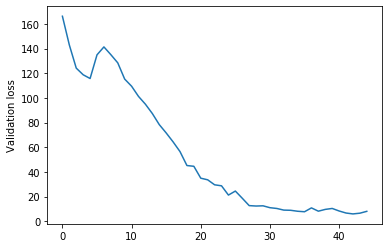

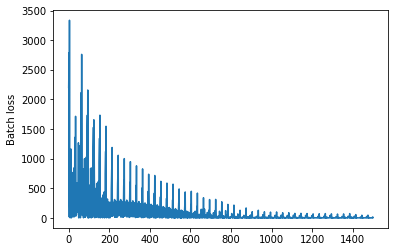

In [5]:
if __name__ == "__main__":
    learner = CarBadnessGuesser()
    torch.backends.cudnn.enabled = False
    learner.train()